<img src="qiskit-heading.png" alt="Note: In order for images to show up in this jupyter notebook you need to select File => Trusted Notebook" align="middle">

# *Getting started with Qiskit Chemistry*

Notebook prepared for QuID 2019 school Sep 10th 2019

***
### Contributors
Lukas Moeller<sup>[1]</sup>, Igor Sokolov<sup>[1]</sup>, Pauline Ollitrault<sup>[1]</sup>, Panagiotis Barkoutsos<sup>[1]</sup>, Richard Chen<sup>[2]</sup>, Antonio Mezzacapo<sup>[2]</sup>, Marco Pistoia<sup>[2]</sup>, Stephen Wood<sup>[2]</sup>, Shaohan Hu<sup>[2]</sup>, Peng Liu<sup>[2]</sup>, Jay Gambetta<sup>[2]</sup>
### Affiliation
- <sup>[1]</sup>IBM Research Zuerich
- <sup>[2]</sup>IBMQ

### Installation

You have to have Qiskit installed to run it. See https://qiskit.org/documentation/install.html for installation guidelines.

For a last minite installation (without Anaconda):

- install Python 3.7 by downloading from official website

and then, in the Terminal, write
- pip install qiskit 

this will install qiskit-aqua that contains the chemistry package and all dependencies.

### Introduction
This notebook introduces you to Qiskit Chemistry. It demonstrates the computation of the ground state of molecular Hydrogen using the Variational Quantum Eigensolver (VQE). Different variational forms and qubit 
mappings can be used.

### Variational algorithm for quantum chemistry problems

In order to find the optimal parameters $\boldsymbol\theta^*$ that correspond to the ground state wavefunction, we set up a closed optimization loop between quantum and classical computer, based on some stochastic or gradient-based optimization routine. 

1. Map the fermionic Hamiltonian $H$ to a qubit Hamiltonian $H_P$.
2. Choose the maximum depth and type of the quantum circuit (Variational Form) to efficiently explore the Hilbert space.
3. Choose a set of controls $\boldsymbol\theta$ and make a trial function $|\psi(\boldsymbol\theta)\rangle$. 
4. Evaluate the energy $E(\boldsymbol\theta) = \langle\psi(\boldsymbol\theta)~|H_P|~\psi(\boldsymbol\theta)\rangle$ by sampling each Pauli term individually, or sets of Pauli terms (grouped commuting Paulis) that can be measured in the same tensor product basis.
5. Use a classical optimizer (SPSA, L-BFGS-B, COBYLA ...) to choose a new set of controls $\boldsymbol\theta$.
6. Run the classical optimization until the energy has converged, hopefully close to the real solution $\boldsymbol\theta^*$, global minimum, and return the last value of $E(\boldsymbol\theta)$.


References and additional details:

[1] A. Kandala, A. Mezzacapo, K. Temme, M. Takita, M. Brink, J. M. Chow, and J. M. Gambetta, *Hardware-efficient Variational Quantum Eigensolver for Small Molecules and Quantum Magnets*, Nature 549, 242 (2017), and references therein.

[2] Panagiotis Kl. Barkoutsos, Jerome F. Gonthier, Igor Sokolov, Nikolaj Moll, Gian Salis, Andreas Fuhrer, Marc Ganzhorn, Daniel J. Egger, Matthias Troyer, Antonio Mezzacapo, Stefan Filipp, and Ivano Tavernelli *Quantum algorithms for electronic structure calculations: Particle-hole Hamiltonian and optimized wave-function expansions* Phys. Rev. A 98, 022322 – Published 20 August 2018

### Starting with H2

In this notebook, we decompose the computation of the ground state energy of a molecule into 4 steps:
  1. Define a molecule and get integrals `h1, h2` from a computational chemistry driver (PySCF in this case)
  2. Construct a Fermionic Hamiltonian and map it onto a qubit Hamiltonian using a fermion-to-qubit `mapping`.
  3. Instantiate and initialize dynamically-loaded algorithmic components, such as the quantum algorithm `vqe`, the `optimizer` and `variational form` it will use, and the `initial_state` to initialize the variational form.
  4. Run the algorithm on a quantum `backend` and retrieve the results.

First, we have to import the necessary components to run our simulation. We will explain the different components at the point, where they are used.

In [197]:
# import common packages

import numpy as np
import matplotlib.pyplot as plt

from qiskit import Aer, IBMQ, QuantumRegister
from qiskit.providers.ibmq import least_busy
from qiskit.providers.aer import noise

# lib from Qiskit Aqua

from qiskit.aqua import Operator, QuantumInstance
from qiskit.aqua.algorithms import VQE, ExactEigensolver
from qiskit.aqua.components.optimizers import COBYLA, SPSA, L_BFGS_B
from qiskit.aqua.components.variational_forms import RY, RYRZ, SwapRZ


# lib from Qiskit Aqua Chemistry

from qiskit.chemistry import QiskitChemistry
from qiskit.chemistry import FermionicOperator
from qiskit.chemistry.drivers import PySCFDriver, UnitsType
from qiskit.chemistry.aqua_extensions.components.variational_forms import UCCSD
from qiskit.chemistry.aqua_extensions.components.initial_states import HartreeFock

# setup qiskit.chemistry logging

import logging
from qiskit.chemistry import set_qiskit_chemistry_logging

# function that allows us to create multiple figures in single notebook cell
def show_figure(fig):
    dummy_fig = plt.figure()
    new_dummy_fig_manager = dummy_fig.canvas.manager
    new_dummy_fig_manager.canvas.figure = fig
    fig.set_canvas(new_dummy_fig_manager.canvas)

Set the logger specific level of prints so you can get all information on what is actually happening for understanding every step of code's execution. 

- set `logging.DEBUG` for maximum amount of information on the execution and `logging.ERROR` for only displaying errors.
- `logging.INFO` allows to monitor the execution without getting too much information.

In [198]:
set_qiskit_chemistry_logging(logging.INFO) # choose among DEBUG, INFO, WARNING, ERROR, CRITICAL and NOTSET

### Step 1: define a molecule and compute the integrals
Here, we use H2 in sto3g basis with `PySCFDriver` as an example.
The `molecule` object records the information from the PySCF driver. You can also use other drivers such as Gaussian,

In [199]:
driver = PySCFDriver(atom='H .0 .0 .0; H .0 .0 1.6', unit=UnitsType.ANGSTROM,
                     charge=0, spin=0, basis='sto3g')
molecule = driver.run()

2019-09-09 23:09:17,126:qiskit.chemistry.drivers.pyscfd.integrals:INFO: PySCF kernel() converged: True, e(hf): -0.8817324499460555
2019-09-09 23:09:17,129:qiskit.chemistry.drivers.pyscfd.integrals:INFO: HF Electronic dipole moment: [-0.        -0.        -3.0235618]
2019-09-09 23:09:17,130:qiskit.chemistry.drivers.pyscfd.integrals:INFO: Nuclear dipole moment: [0.        0.        3.0235618]
2019-09-09 23:09:17,131:qiskit.chemistry.drivers.pyscfd.integrals:INFO: Total dipole moment: [0. 0. 0.]


Extract the data from the molecule object

In [201]:
nuclear_repulsion_energy = molecule.nuclear_repulsion_energy
num_particles = molecule.num_alpha + molecule.num_beta
num_spin_orbitals = molecule.num_orbitals * 2

print("HF energy: {}".format(molecule.hf_energy - molecule.nuclear_repulsion_energy))
print("# of electrons: {}".format(num_particles))
print("# of spin orbitals: {}".format(num_spin_orbitals))

HF energy: -1.2124682067710555
# of electrons: 2
# of spin orbitals: 4


If you want to know all the contents of the given class to know more do

In [203]:
print("Contents of molecule object: \n{}".format(sorted(molecule.__dir__())))

Contents of molecule object: 
['BOHR', 'DEBYE', 'QMOLECULE_VERSION', 'Z', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_filename', 'atom_symbol', 'atom_xyz', 'core_orbitals', 'eri', 'filename', 'has_dipole_integrals', 'hcore', 'hcore_B', 'hf_energy', 'kinetic', 'load', 'log', 'mo_coeff', 'mo_coeff_B', 'mo_eri_ints', 'mo_eri_ints_BA', 'mo_eri_ints_BB', 'mo_onee_ints', 'mo_onee_ints_B', 'molecular_charge', 'multiplicity', 'nuclear_dipole_moment', 'nuclear_repulsion_energy', 'num_alpha', 'num_atoms', 'num_beta', 'num_orbitals', 'one_body_integrals', 'onee_to_spin', 'oneeints2mo', 'orbital_energies', 'orbital_energies_B', 'origin_driver_config', 'origin_driver_name', 'origin_driver_version', 'ov

You can also use the `shift+tab` command when clicking on a class/method to produce its docstring in Jupyter Notebook.

### Step 2: Prepare qubit Hamiltonian


#### Fermionic Hamiltonians

The Hamiltonians describing systems of interacting fermions can be expressed in second quantization language, considering fermionic creation (annihilation) operators $a^\dagger_\alpha(a_\alpha)$, relative to the $\alpha$-th fermionic mode. In the case of molecules, the $\alpha$ labels stand for the different atomic or molecular orbitals. 

Within the second-quantization framework, a generic molecular Hamiltonian with $M$ orbitals can be written as 
$$H =H_1+H_2=\sum_{\alpha, \beta=0}^{M-1} h_{1,\alpha \beta} \, a^\dagger_{\alpha} a_{\beta} +\frac{1}{2}  \sum_{\alpha, \beta, \gamma, \delta = 0}^{M-1} h_{2,\alpha \beta \gamma \delta}\, a^\dagger_{\alpha} a^\dagger_{\gamma} a_{\delta} a_{\beta},$$
with the one-body terms representing the kinetic energy of the electrons and the potential energy that they experience in the presence of the nuclei, 
$$ h_{1,\alpha\beta}=\int d\boldsymbol x_1\Psi_\alpha(\boldsymbol{x}_1) \left(-\frac{\boldsymbol\nabla_1^2}{2}+\sum_{i} \frac{Z_i}{|\boldsymbol{r}_{1i}|}\right)\Psi_\beta (\boldsymbol{x}_1),$$
and their interactions via Coulomb forces 
$$ h_{2,\alpha\beta\gamma\delta}=\int\int d \boldsymbol{x}_1 d \boldsymbol{x}_2 \Psi_\alpha^*(\boldsymbol{x}_1)\Psi_\beta(\boldsymbol{x}_1)\frac{1}{|\boldsymbol{r}_{12}|}\Psi_\gamma^*(\boldsymbol{x}_2)\Psi_\delta(\boldsymbol{x}_2),$$
where we have defined the nuclei charges $Z_i$, the nuclei-electron and electron-electron separations $\boldsymbol{r}_{1i}$ and $\boldsymbol{r}_{12}$, the $\alpha$-th orbital wavefunction $\Psi_\alpha(\boldsymbol{x}_1)$, and we have assumed that the spin is conserved in the spin-orbital indices $\alpha,\beta$ and $\alpha,\beta,\gamma,\delta$.

[1] A. Kandala, A. Mezzacapo, K. Temme, M. Takita, M. Brink, J. M. Chow, and J. M. Gambetta, *Hardware-efficient Variational Quantum Eigensolver for Small Molecules and Quantum Magnets*, Nature 549, 242 (2017)

Now we can create a `FermionicOperator` that represents the electronic Hamiltonian

In [204]:
# get the integrals from molecule object
h1 = molecule.one_body_integrals
h2 = molecule.two_body_integrals

# create a fermionic operator
ferOp = FermionicOperator(h1=h1, h2=h2)

Here, we define the `map_type` for mapping the fermionic Hamitonian to the qubit Hamiltonian to transform the creation and anihilation operators into Pauli strings.
For the particular `'parity'` mapping, we can further reduce the number of qubits needed, later on.

In [206]:
map_type = 'parity' # 'jordan_wigner', 'parity', 'bravyi_kitaev', 'bksf'

For more information about fermion-to-qubit mappings such as parity refer for example to: 

[3] Jacob T. Seeley, Martin J. Richard, and Peter J. Love *The Bravyi-Kitaev transformation for quantum computation of electronic structure*
J. Chem. Phys. 137, 224109 (2012); https://doi.org/10.1063/1.4768229

We get a list of Pauli strings, which represent our Hamiltonian in the quantum computer.

In [207]:
# if 'parity' mapping is selected, reduce the number of qubits (-2 qubits)
qubit_reduction = True if map_type == 'parity' else False

qubitOp = ferOp.mapping(map_type=map_type, threshold=10**-10) # paulis with coefs below threshold are not considered
qubitOp = qubitOp.two_qubit_reduced_operator(num_particles) if qubit_reduction else qubitOp
qubitOp.chop(10**-10) # cut out the pauli strings with prefacator smaller then

print(qubitOp)
qubitOp.paulis

# to see all the contents of given class
# qubitOp.__dir__()
# one can group the Paulis
# qubitOp.to_grouped_paulis()
# qubitOp.paulis

Representation: paulis, qubits: 2, size: 5


/anaconda3/envs/qiskit_camp/lib/python3.7/site-packages/qiskit/aqua/operators/base_operator.py:182: DeprecationWarning: two_qubit_reduced_operator method is deprecated and it will be removed after 0.6. Now it is moved to the `Z2Symmetries` class as a classmethod. Z2Symmeteries.two_qubit_reduction(num_particles)
  DeprecationWarning)


[[(-0.9932985015661868+0j), Pauli(z=[False, False], x=[False, False])],
 [(0.11130874730832119+0j), Pauli(z=[True, False], x=[False, False])],
 [(-0.11130874730832119+0j), Pauli(z=[False, True], x=[False, False])],
 [(-0.0034477894117742047+0j), Pauli(z=[True, True], x=[False, False])],
 [(0.23590128539850805+0j), Pauli(z=[False, False], x=[True, True])]]

where the x,y,z are the usual Pauli matrices:

$X= \begin{pmatrix} 0&1 \\ 1&0 \end{pmatrix}$, 
$Y= \begin{pmatrix} 0&-i \\ i&0 \end{pmatrix}$, 
$Z= \begin{pmatrix} 1&0 \\ 0&-1 \end{pmatrix}$

and the notation 
`Pauli(z=[False, False], x=[True, True])`
represents the Pauli string $(Z^{0}X^{1})\otimes (Z^{0}X^{1}) = X \otimes X = XX$ 

using the property $Z^1X^1 = iY$.
We can also print the Paulis in a more convinient form:


In [208]:
for pauli in qubitOp.paulis:
    print(pauli[0],str(pauli[1]))

(-0.9932985015661868+0j) II
(0.11130874730832119+0j) IZ
(-0.11130874730832119+0j) ZI
(-0.0034477894117742047+0j) ZZ
(0.23590128539850805+0j) XX


### Step 3: Initiate and configure dynamically-loaded instances

#### Scheme of Variational Quantum Eigensolver (VQE) Algorithm
<img title="Schematic of VQE" src="vqe.jpg" alt="Drawing" style="width: 700px;"/>

[3] Nikolaj Moll et al 2018 Quantum Sci. Technol. 3 030503

To run VQE we require
- VQE algorithm
- Classical Optimizer
- Prepare the initial state into Hartree-Fock state
- Variational form
- Backend (where to run our algorithm)

Here we setup the classical optimizer. We can choose between different optimizers in Qiskit. Each optimizer can have different meanings of iterations $\neq$ number of energy evaluations (calculate gradients for all dimensions then perform a step). So it is advised to look at each optimizer and understand the parameters.

In [174]:
max_iter = 200 # maximum number of iterations

# optimizer = COBYLA(maxiter=max_iter)
# optimizer = SPSA(maxiter=max_iter)
optimizer = L_BFGS_B(maxiter=max_iter)

Now we have to setup an initial state for our optimization to start with. We can use the `HartreeFock` state.

2019-09-09 22:23:11,059:qiskit.chemistry.aqua_extensions.components.initial_states.hartree_fock:INFO: We assume that the number of alphas and betas are the same.


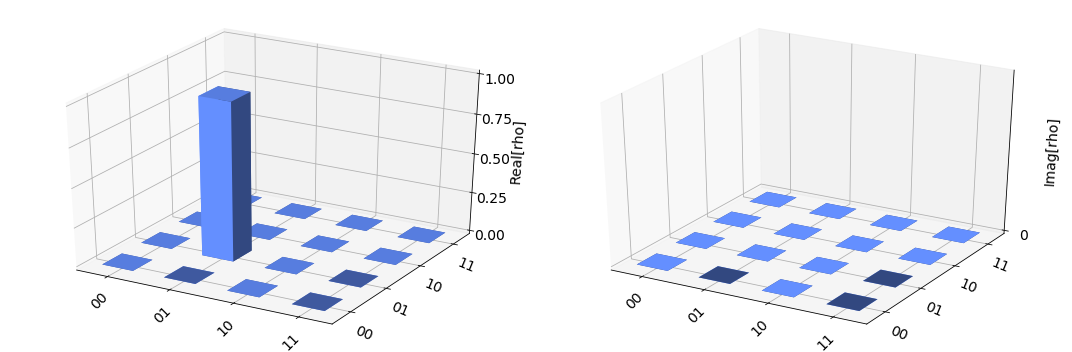

In [175]:
HF_state = HartreeFock(qubitOp.num_qubits, num_spin_orbitals, num_particles, map_type, 
                       qubit_reduction)
HF_state_vec = HF_state.construct_circuit(mode='vector')

# we can use qiskit's vizualisation module to plot the state
from qiskit.visualization import plot_state_city
plot_state_city(HF_state_vec)


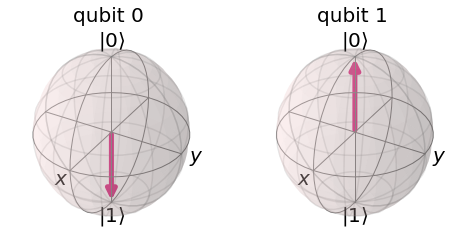

In [181]:
# you might want to visualise on the Bloch sphere for a non-superposition state
from qiskit.visualization import plot_state_city, plot_bloch_multivector
plot_bloch_multivector(HF_state_vec)

### Variational Forms
#### Hardware efficient heuristic Ansatz
Note that, as opposed to the classical case, in the case of a quantum chemistry Hamiltonian one has to sample over non-computational states that are superpositions, and therefore take advantage of using a quantum computer in the sampling part of the algorithm. Motivated by the quantum nature of the answer, we define a variational trial ansatz in this way: 

$$|\psi(\boldsymbol\theta)\rangle  = [U_\mathrm{single}(\boldsymbol\theta) U_\mathrm{entangler}]^m |+\rangle$$

where $U_\mathrm{entangler}$ is a collection of cPhase gates (fully entangling gates), $U_\mathrm{single}(\boldsymbol\theta) = \prod_{i=1}^n Y(\theta_{i})Z(\theta_{n+i})$ are single-qubit $Y$ and $Z$ rotation, $n$ is the number of qubits and $m$ is the depth of the quantum circuit.

References and additional details:

[1] A. Kandala, A. Mezzacapo, K. Temme, M. Takita, M. Brink, J. M. Chow, and J. M. Gambetta, *Hardware-efficient Variational Quantum Eigensolver for Small Molecules and Quantum Magnets*, Nature 549, 242 (2017)

#### Unitary Coupled Cluster (UCC) Ansatz 

Another approach is to take inspiration from the classical UCC and electronic Hamiltonian and parameterise each excitation (single $\hat{T}_{1}(\vec{\theta})=\sum_{i ; m} \theta_{i}^{m} \hat{a}_{m}^{\dagger} \hat{a}_{i}$ and double $\hat{T}_{2}(\vec{\theta})=\frac{1}{2} \sum_{i, j ; m, n} \theta_{i, j}^{m, n} \hat{a}_{n}^{\dagger} \hat{a}_{m}^{\dagger} \hat{a}_{j} \hat{a}_{i}$) in operator $\hat T(\vec{\theta}) = \hat{T}_{1}(\vec{\theta}) + \hat{T}_{2}(\vec{\theta}) $ with an angle $\theta$. The unitary coupled cluster (UCC) wavefunction is given by:
$$|\psi(\boldsymbol\theta)\rangle= e^{\hat{T}(\theta)-\hat{T}^{\dagger}(\theta)}\left|\Phi_{0}\right\rangle$$
where the cluster operator is
$$ U(\boldsymbol\theta)=e^{\hat{T}(\theta)-\hat{T}^{\dagger}(\theta)} $$
the 
where $\left|\Phi_{0}\right\rangle$ is the HF state (e.g. $\left|1100\right\rangle$ for H2 in STO-3G basis)

In [177]:
var_form_uccsd = UCCSD(qubitOp.num_qubits, depth=1, 
                   num_orbitals=num_spin_orbitals, num_particles=num_particles, 
                   active_occupied=None, active_unoccupied=None, # you could modify the active space here 
                   initial_state=HF_state, qubit_mapping=map_type,
                   two_qubit_reduction=qubit_reduction, num_time_slices=1)

var_form_swaprz = SwapRZ(qubitOp.num_qubits, depth=1, 
                   initial_state=HF_state)

var_form_ryrz = RYRZ(qubitOp.num_qubits, depth=1, 
                   initial_state=HF_state)

# var_form_ry = RY(qubitOp.num_qubits, depth=1, 
#                    initial_state=HF_state)

2019-09-09 22:23:13,866:qiskit.chemistry.aqua_extensions.components.variational_forms.uccsd:INFO: We assume that the number of alphas and betas are the same.


### [Optional] Setup token to run the experiment on a real device
If you would like to run the experiment on a real device, you need to setup your account first.

Note: If you do not store your token yet, use `IBMQ.save_account('MY_API_TOKEN')` to store it first.
### Choose a simulator or real device
You can use the `qasm_simulator` or `ibmq_qasm_simulator` (cloud qasm simulator) to simulate faithfully the operations a real quantum computer would do. If you just want to simulate the processing of a quantum computer for now, you have to use `Aer`, which provides you with the `statevector_simulator`.

In [22]:
simultation_type = 'state_vector'# qasm, qasm_cloud, real_device, state_vector

In [23]:
if simultation_type == 'qasm':
    
    sv_mode = False
    qasm_simulator = Aer.get_backend('qasm_simulator') # qasm_simulator, ibmq_qasm_simulator

    # uncomment this and put your token from the IBMQ website.
    #IBMQ.save_account('Your IBMQ API-token', overwrite=True)
    
    IBMQ.load_accounts() # connect with your token to IBMQ
    provider = IBMQ.get_provider(hub='ibm-q', group='open', project='main')
    print(provider.backends()) # lists available backends
    
    # set the noise model
    device = provider.get_backend('ibmq_16_melbourne') # ibmq_16_melbourne 
    properties = device.properties()
    coupling_map = device.configuration().coupling_map
    noise_model = noise.device.basic_device_noise_model(properties)
    basis_gates = noise_model.basis_gates
    shots = 8192 # choose the maximal number of shots (8192 is max on the ibmq_qasm_simulator)
    num_qubits = qubitOp.num_qubits
    
    # run on qasm_simulator 
    quantum_instance = QuantumInstance(qasm_simulator, shots=shots, basis_gates=basis_gates, coupling_map=coupling_map, noise_model=noise_model)

    # all the details of noise model
    print(noise_model.to_dict())
    
elif simultation_type == 'qasm_cloud':
    
    sv_mode = False
    # uncomment this and put your token from the IBMQ website.
    #IBMQ.save_account('Your IBMQ API-token', overwrite=True)
    IBMQ.load_accounts() # connect with your token to IBMQ
    provider = IBMQ.get_provider(hub='ibm-q', group='open', project='main')
    print(provider.backends()) # lists available backends
    
    qasm_simulator_cloud = provider.get_backend('ibmq_qasm_simulator') # ibmq_16_melbourne , ibmq_qasm_simulator
    # set the qasm cloud simulator 
    quantum_instance = QuantumInstance(qasm_simulator_cloud, shots=shots)

    # all the details of noise model
    print(noise_model.to_dict())

elif simultation_type == 'real_device':
    
    sv_mode = False
    # uncomment this and put your token from the IBMQ website.
    #IBMQ.save_account('Your IBMQ API-token', overwrite=True)
    
    IBMQ.load_accounts() # connect with your token to IBMQ
    provider = IBMQ.get_provider(hub='ibm-q', group='open', project='main')
    print(provider.backends()) # lists available backends
    
    # set the noise model
    device = provider.get_backend('ibmq_16_melbourne') # ibmq_16_melbourne 
    
    # run on qasm_simulator 
    quantum_instance = QuantumInstance(device, shots=shots)

    # all the details of noise model
    print(noise_model.to_dict())
    
elif simultation_type == 'state_vector':
    
    sv_simulator = Aer.get_backend('statevector_simulator')
    quantum_instance = QuantumInstance(sv_simulator) 
    sv_mode = True
    num_qubits = qubitOp.num_qubits
else:
    raise Exception('Please select for simultation_type == qasm, qasm_cloud, real_device, state_vector')


2019-09-09 17:59:53,305:qiskit.aqua.quantum_instance:INFO: statevector backend only works with shot=1, change shots from 1024 to 1.
2019-09-09 17:59:53,306:qiskit.aqua.quantum_instance:INFO: 
Qiskit Terra version: 0.9.0
Backend: 'statevector_simulator (AerProvider)', with following setting:
{'basis_gates': ['u1', 'u2', 'u3', 'cx', 'cz', 'cu1', 'id', 'x', 'y', 'z', 'h', 's', 'sdg', 't', 'tdg', 'ccx', 'swap', 'multiplexer', 'snapshot', 'unitary', 'reset', 'initialize'], 'coupling_map': None}
{'pass_manager': None, 'initial_layout': None, 'seed_transpiler': None, 'optimization_level': None}
RunConfig(max_credits=10, shots=1)
{'timeout': None}
{}
{}
Measurement mitigation: None


If you want more details on the noise models and , refer to tutorial:

https://github.com/Qiskit/qiskit-iqx-tutorials/blob/master/qiskit/advanced/aer/2_device_noise_simulation.ipynb

We prepared everything to setup the Variational Quantum Eigensolver at this point. We initialize 3 different VQE objects to show the circuits (`uccsd, ryrz, swaprz`) each one will use to evalute the energy.

In [24]:
vqe_uccsd = VQE(qubitOp, var_form_uccsd, optimizer)
vqe_ryrz = VQE(qubitOp, var_form_ryrz, optimizer)
vqe_swaprz = VQE(qubitOp, var_form_swaprz, optimizer)

2019-09-09 17:59:54,791:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: 
==================== Setting of VQE ============================
Algorithm: VQE
-- quantum_instance: None
-- var_form: <qiskit.chemistry.aqua_extensions.components.variational_forms.uccsd.UCCSD object at 0x134dc5c50>
-- optimizer: <qiskit.aqua.components.optimizers.l_bfgs_b.L_BFGS_B object at 0x1345a7400>
-- cost_fn: <bound method VQE._energy_evaluation of <qiskit.aqua.algorithms.adaptive.vqe.vqe.VQE object at 0x13886c080>>
-- initial_point: [0. 0. 0.]
-- callback: None
-- operator: Representation: paulis, qubits: 2, size: 5
-- eval_count: 0
-- aux_operators: []
-- auto_conversion: True
Variational Form: UCCSD
-- num_parameters: 3
-- num_qubits: 2
-- bounds: [(-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793)]
-- z2_symmetries: Z2 symmetries:
Symmetries:
Single-Qubit Pauli X:
Cliffords:
Qubit index:
[]
Tapering values:
[]
-- depth: 1
-- num_orbit

To get a better understanding, what is happening on the quantum computer, we can have a look on the circuit that is executed. For each Pauli, we have a circuit that is used to evaluate its expectation value.

Circuit for: II
Circuit for: IZ
Circuit for: ZI
Circuit for: ZZ
Circuit for: XX


/anaconda3/envs/qiskit_camp/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  


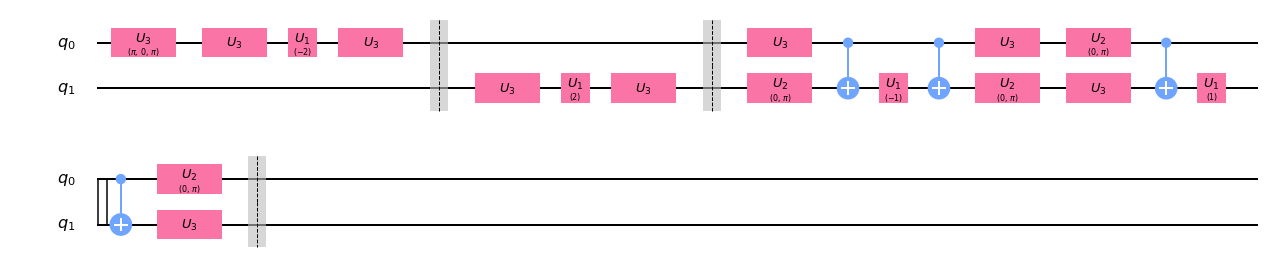

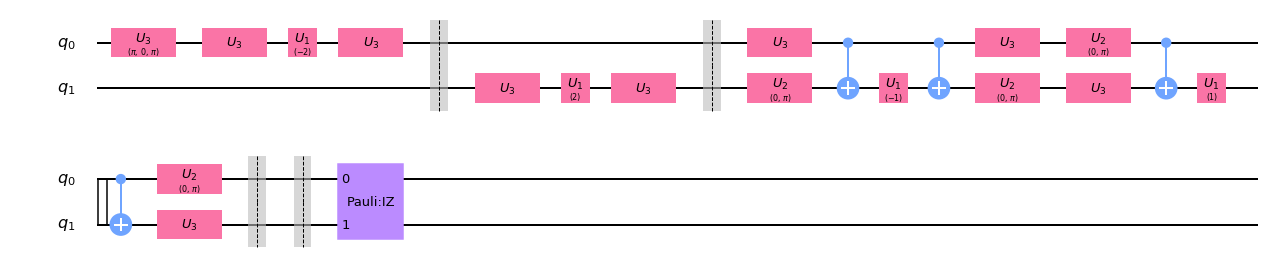

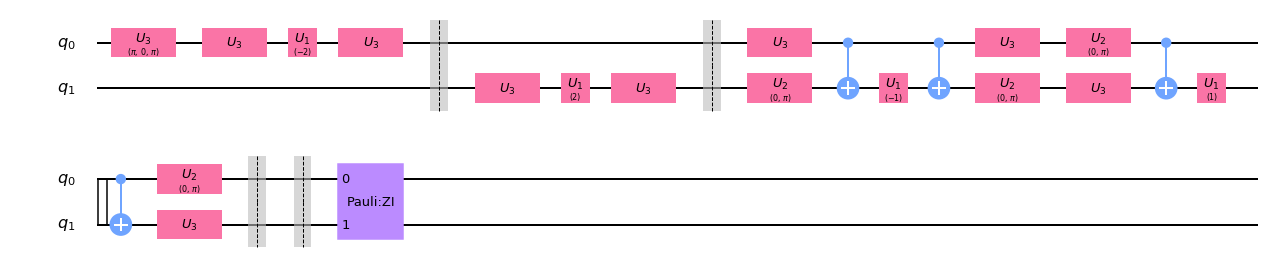

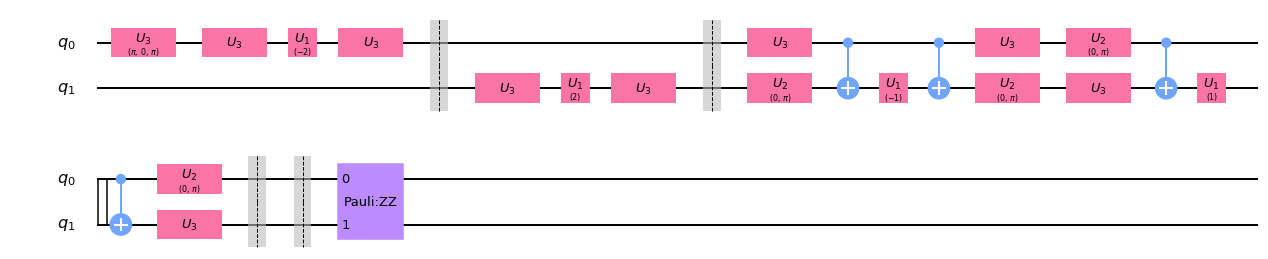

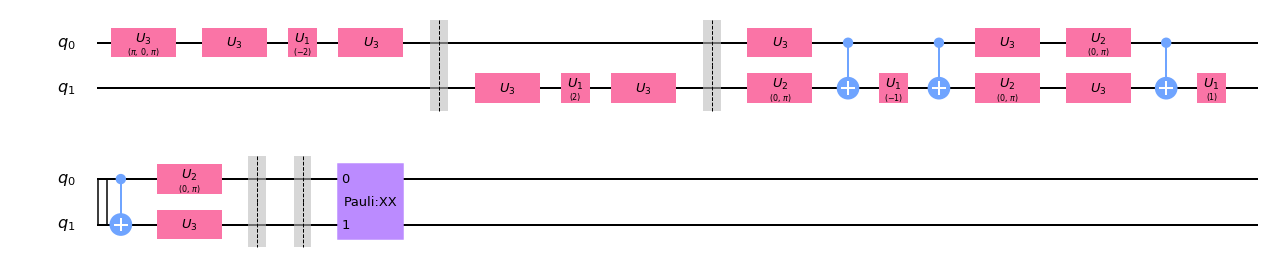

In [25]:
for pauli in qubitOp.paulis:
    print('Circuit for:', pauli[1])

circuit_uccsd = vqe_uccsd.construct_circuit(statevector_mode=sv_mode, parameter=np.ones(var_form_uccsd._num_parameters))
for i in range(len(circuit_uccsd)):
    fig = circuit_uccsd[i].draw(output='mpl')
    show_figure(fig)
    fig.show()

where all single-qubit operations are compiled down the **physical gates**:
$$U_3(\theta,\phi,\lambda) = \begin{pmatrix} \cos(\theta/2) & -e^{i\lambda}\sin(\theta/2) \\ e^{i\phi}\sin(\theta/2)  
& e^{i\lambda+i\phi}\cos(\theta/2) \end{pmatrix}$$, $$U_1(\lambda) = U_3(0,0,\lambda) = \begin{pmatrix} 1 & 0 \\ 0 & e^{i\lambda} \end{pmatrix}$$, $$U_2(\phi,\lambda) = U_3(\pi/2,\phi,\lambda) = \frac{1}{\sqrt{2}}\begin{pmatrix} 1 & -e^{i\lambda} \\ e^{i\phi} & e^{i\lambda+i\phi} \end{pmatrix}$$
for example the Hadamard gate is $U_2(0,\pi)$.

We read those graphs from left to right with $\left|q_0q_1\right\rangle$ notation convention. 
Our system requires 2 qubits $q_0$ and $q_1$ reduced from 4 due to two-qubit reduction from the parity mapping. 
The qubits always start to be in the initial state $|0\rangle$. 
Afterwards we act with unitary operations on the qubits. 

### Hardware-efficient Ansatz
#### particle-conserving Variational Form

We can also make a low-depth, particle conserving ansatz (like UCCSD), by using SWAP gates as entanglers to preserve the number of 1's (electrons) in the state.

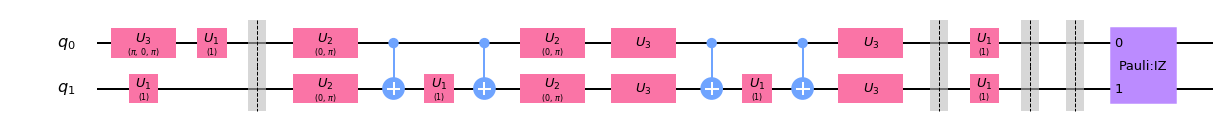

In [26]:
circuit_swaprz = vqe_swaprz.construct_circuit(statevector_mode=sv_mode, parameter=np.ones(var_form_swaprz._num_parameters))
circuit_swaprz[1].draw(output='mpl')

#### particle-non-conserving Variational Form

By using the CNOTs as entanglers we can get out of the $N_{el}$ Fock subspace and obtain a converged state which can be with different average particle number.

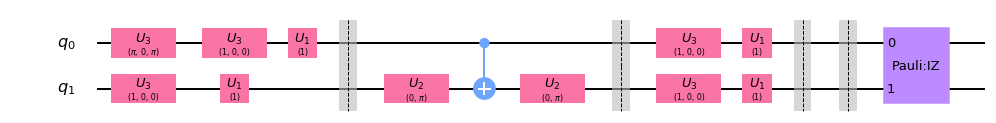

In [27]:
circuit_ryrz = vqe_ryrz.construct_circuit(statevector_mode=sv_mode, parameter=np.ones(var_form_ryrz._num_parameters))
circuit_ryrz[1].draw(output='mpl')

### Step 4: Run VQE algorithm and retrieve the results
The smallest eigenvalue is stored in the first entry of the `eigvals` key.

Note: Until now we have not done any calculation on the quantum computer. During the next step the algorithm is run on the real device or using the simulator.

In [28]:
results = vqe_uccsd.run(quantum_instance)
print('The computed ground state energy is: {:.12f}'.format(results['eigvals'][0]))
print('The total ground state energy is: {:.12f}'.format(results['eigvals'][0] + nuclear_repulsion_energy))
print("Parameters: {}".format(results['opt_params']))

2019-09-09 17:59:59,294:qiskit.aqua.algorithms.adaptive.vq_algorithm:INFO: Starting optimizer.
bounds=[(-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793)]
initial point=[0. 0. 0.]
2019-09-09 17:59:59,473:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 1 returned -1.212468206771055
2019-09-09 17:59:59,642:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 2 returned -1.212468206771055
2019-09-09 17:59:59,813:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 3 returned -1.2124682067710548
2019-09-09 17:59:59,990:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 4 returned -1.212468202053029
2019-09-09 18:00:00,169:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 5 returned -1.3115032151715336
2019-09-09 18:00:00,344:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 6 returned -1.3115032151715336
2019-09-09 18:00:00,527:qiskit.aqua.al

The computed ground state energy is: -1.314208485858
The total ground state energy is: -0.983472729033
Parameters: [ 0.00000000e+00 -3.58971974e-08 -4.07180577e-01]


The Variational Quantum Eigensolver did arrive at the minimum. As it is a variatonal method we know that we are above the "exact" solution. This is indeed the property which is used, when running the VQE, because we know that every solution we find the one that has a lower energy is better than our previous one.

## Go a step further and evolve our system in time

Now we want to evolve our system in time, starting at an initial state. e.g. the Hartree Fock state, which we also used to start our optimization. 

In [190]:
evolution_time = 100 # how many time steps
num_time_slices = 4 # number of Trotter steps
qr = QuantumRegister(num_qubits,'q')
initial_circuit = HF_state.construct_circuit(mode='circuit')

Now we time evolve our state with time-evolution operator by exponentiating the `qubitOp` $$e^{-i\hat{H}t} \underbrace{=}_{Trotter}\prod_{n} e^{-i\hat{H}t/n}$$ that is our electronic Hamiltonian and `num_time_slices`$=n$.

/anaconda3/envs/qiskit_camp/lib/python3.7/site-packages/qiskit/aqua/operators/weighted_pauli_operator.py:863: DeprecationWarning: evo_mode option is deprecated and it will be removed after 0.6, Every operator knows which mode is using, not need to indicate the mode.
  DeprecationWarning)


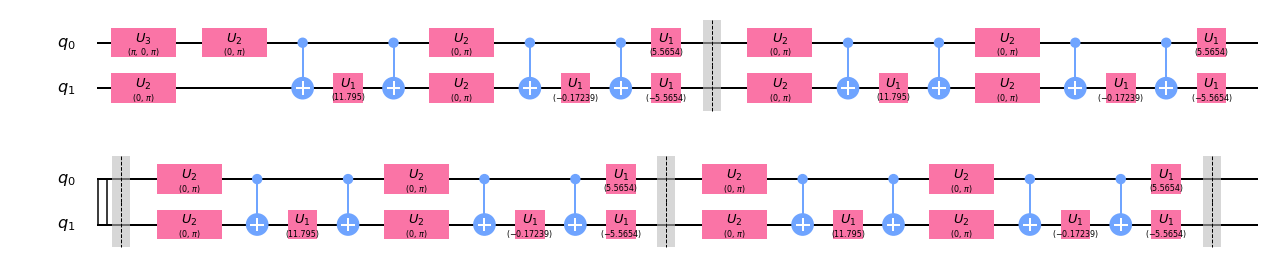

In [191]:
evolution_circuit = qubitOp.evolve(state_in=initial_circuit, evo_time=evolution_time, evo_mode='circuit',num_time_slices=num_time_slices, expansion_mode='trotter')
evolution_circuit.draw(output='mpl')

We also want to run the circuit we just constructed. As a result we get the evolving state vector of the system for different evolution times `evo_time`.

In [192]:
max_time=evolution_time
statevector_of_t = np.zeros([max_time,2*num_qubits])
for evo_t in range(max_time):
    evolution_circuit = qubitOp.evolve(state_in=initial_circuit, evo_time=evo_t, evo_mode='circuit',num_time_slices=num_time_slices, expansion_mode='trotter')
    result = quantum_instance.execute(evolution_circuit)
    statevector_of_t[evo_t,:] = np.asarray(result.get_statevector(evolution_circuit))

/anaconda3/envs/qiskit_camp/lib/python3.7/site-packages/qiskit/aqua/operators/weighted_pauli_operator.py:863: DeprecationWarning: evo_mode option is deprecated and it will be removed after 0.6, Every operator knows which mode is using, not need to indicate the mode.
  DeprecationWarning)
/anaconda3/envs/qiskit_camp/lib/python3.7/site-packages/ipykernel_launcher.py:6: ComplexWarning: Casting complex values to real discards the imaginary part
  
/anaconda3/envs/qiskit_camp/lib/python3.7/site-packages/qiskit/aqua/operators/weighted_pauli_operator.py:863: DeprecationWarning: evo_mode option is deprecated and it will be removed after 0.6, Every operator knows which mode is using, not need to indicate the mode.
  DeprecationWarning)
/anaconda3/envs/qiskit_camp/lib/python3.7/site-packages/qiskit/aqua/operators/weighted_pauli_operator.py:863: DeprecationWarning: evo_mode option is deprecated and it will be removed after 0.6, Every operator knows which mode is using, not need to indicate the mo

/anaconda3/envs/qiskit_camp/lib/python3.7/site-packages/qiskit/aqua/operators/weighted_pauli_operator.py:863: DeprecationWarning: evo_mode option is deprecated and it will be removed after 0.6, Every operator knows which mode is using, not need to indicate the mode.
  DeprecationWarning)
/anaconda3/envs/qiskit_camp/lib/python3.7/site-packages/qiskit/aqua/operators/weighted_pauli_operator.py:863: DeprecationWarning: evo_mode option is deprecated and it will be removed after 0.6, Every operator knows which mode is using, not need to indicate the mode.
  DeprecationWarning)
/anaconda3/envs/qiskit_camp/lib/python3.7/site-packages/qiskit/aqua/operators/weighted_pauli_operator.py:863: DeprecationWarning: evo_mode option is deprecated and it will be removed after 0.6, Every operator knows which mode is using, not need to indicate the mode.
  DeprecationWarning)
/anaconda3/envs/qiskit_camp/lib/python3.7/site-packages/qiskit/aqua/operators/weighted_pauli_operator.py:863: DeprecationWarning: evo

/anaconda3/envs/qiskit_camp/lib/python3.7/site-packages/qiskit/aqua/operators/weighted_pauli_operator.py:863: DeprecationWarning: evo_mode option is deprecated and it will be removed after 0.6, Every operator knows which mode is using, not need to indicate the mode.
  DeprecationWarning)
/anaconda3/envs/qiskit_camp/lib/python3.7/site-packages/qiskit/aqua/operators/weighted_pauli_operator.py:863: DeprecationWarning: evo_mode option is deprecated and it will be removed after 0.6, Every operator knows which mode is using, not need to indicate the mode.
  DeprecationWarning)
/anaconda3/envs/qiskit_camp/lib/python3.7/site-packages/qiskit/aqua/operators/weighted_pauli_operator.py:863: DeprecationWarning: evo_mode option is deprecated and it will be removed after 0.6, Every operator knows which mode is using, not need to indicate the mode.
  DeprecationWarning)
/anaconda3/envs/qiskit_camp/lib/python3.7/site-packages/qiskit/aqua/operators/weighted_pauli_operator.py:863: DeprecationWarning: evo

/anaconda3/envs/qiskit_camp/lib/python3.7/site-packages/qiskit/aqua/operators/weighted_pauli_operator.py:863: DeprecationWarning: evo_mode option is deprecated and it will be removed after 0.6, Every operator knows which mode is using, not need to indicate the mode.
  DeprecationWarning)
/anaconda3/envs/qiskit_camp/lib/python3.7/site-packages/qiskit/aqua/operators/weighted_pauli_operator.py:863: DeprecationWarning: evo_mode option is deprecated and it will be removed after 0.6, Every operator knows which mode is using, not need to indicate the mode.
  DeprecationWarning)
/anaconda3/envs/qiskit_camp/lib/python3.7/site-packages/qiskit/aqua/operators/weighted_pauli_operator.py:863: DeprecationWarning: evo_mode option is deprecated and it will be removed after 0.6, Every operator knows which mode is using, not need to indicate the mode.
  DeprecationWarning)
/anaconda3/envs/qiskit_camp/lib/python3.7/site-packages/qiskit/aqua/operators/weighted_pauli_operator.py:863: DeprecationWarning: evo

### Evolution of the state vector
Here we will plot the 3 fist entries of the state vector.
Then we plot their absolute value.

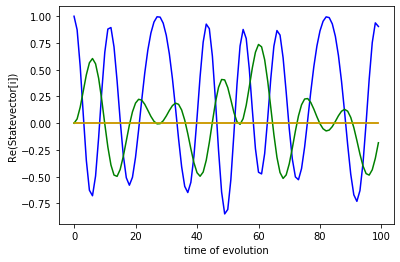

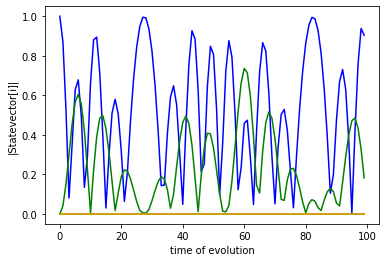

In [193]:
t = np.linspace(0,max_time-1,max_time)

plt.figure(1)
plt.plot(t,statevector_of_t[:,0],'-r', t,statevector_of_t[:,1],'-b', t,statevector_of_t[:,2],'-g', t,statevector_of_t[:,3],'-y')
plt.xlabel('time of evolution')
plt.ylabel('Re(Statevector[i])')
plt.show()

# absolute values of statevector entries
plt.figure(2)
plt.plot(t,np.abs(statevector_of_t[:,0]),'-r', t,np.abs(statevector_of_t[:,1]),'-b', t,np.abs(statevector_of_t[:,2]),'-g', t,np.abs(statevector_of_t[:,3]),'-y')
plt.xlabel('time of evolution')
plt.ylabel('|Statevector[i]|')
plt.show()

### Using Qiskit's visualize 
We can plot the state vector in the density matrix form $\rho =\sum _{j}p_{j}|\psi _{j}\rangle \langle \psi _{j}|$ and see the real and imaginary part of $p_j$ for off-diagonal elements.

/anaconda3/envs/qiskit_camp/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  


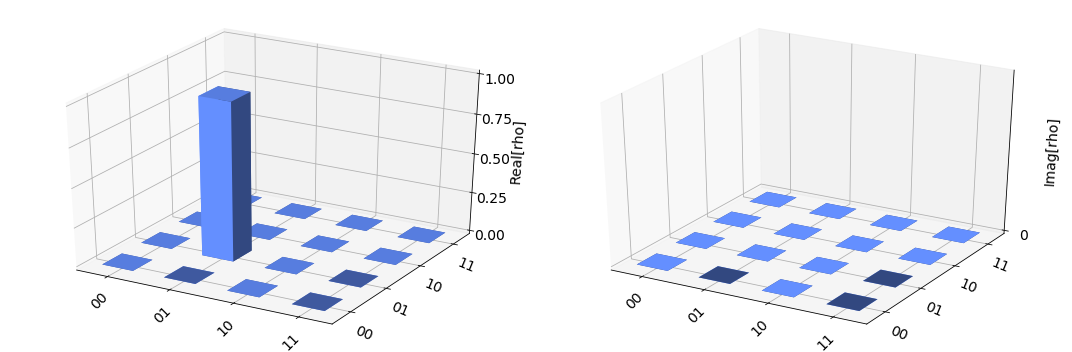

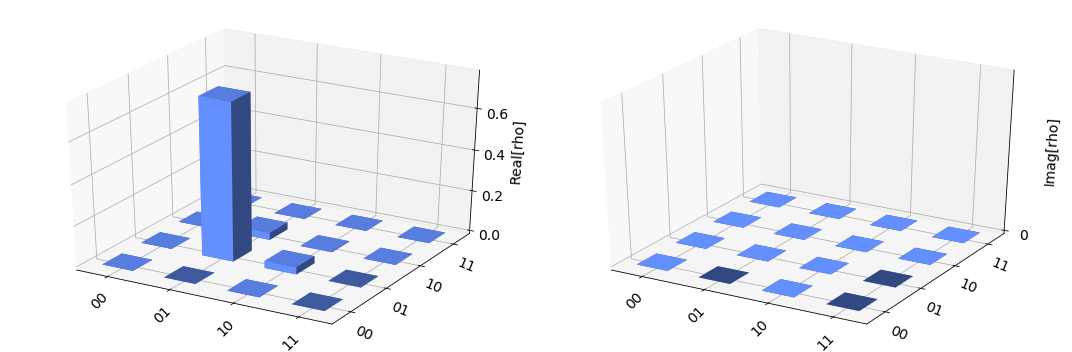

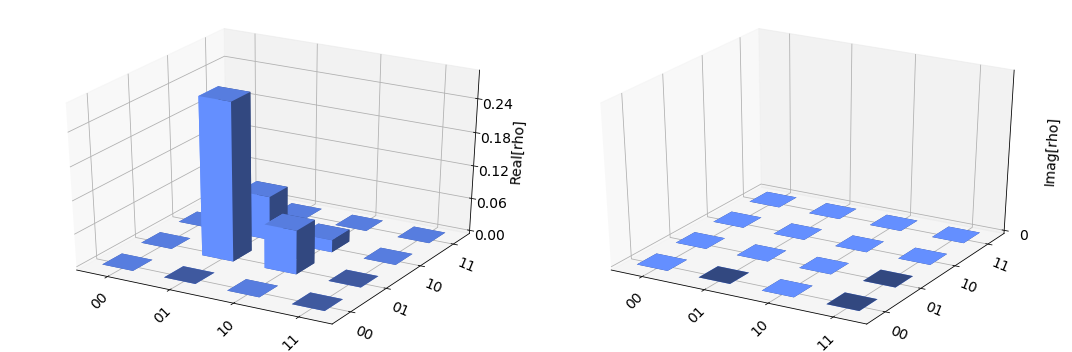

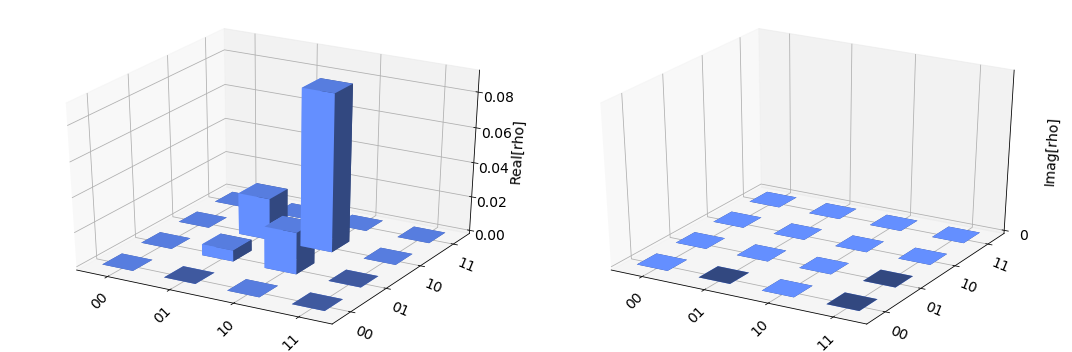

In [194]:
time_min = 0
time_max = 4
for i in range(time_min, time_max):
    fig = plot_state_city(statevector_of_t[i,:])
    show_figure(fig)
    fig.show()

##  H2 using declarative approach
We use this example to show you the declarative approach (provide an input file to qiskit) to solve chemistry problems. But the same is doable in a fully programmatic way (presented so far), especially for those users who are interested in learning the Qiskit Aqua and Qiskit Chemistry APIs as well as contributing new algorithmic components.

It takes the  HDF5 file located at *H2/H2_equilibrium_0.735_sto-3g.hdf5* and reads in the values of integrals. This allows not to recompute them every time and have exactly the same initial data.

In [35]:
# First, we use classical eigendecomposition to get ground state energy (including nuclear repulsion energy) as reference.
qiskit_chemistry_dict = {
    'driver': {'name': 'HDF5'},
    'HDF5': {'hdf5_input': 'H2/H2_equilibrium_0.735_sto-3g.hdf5'},
    'operator': {'name':'hamiltonian', 
                 'qubit_mapping': 'parity', 
                 'two_qubit_reduction': True},
    'algorithm': {'name': 'ExactEigensolver'}
}
solver = QiskitChemistry()
result_classical = solver.run(qiskit_chemistry_dict)

# Second, we use variational quantum eigensolver (VQE)
qiskit_chemistry_dict['algorithm']['name'] = 'VQE'
qiskit_chemistry_dict['optimizer'] = {'name': 'SPSA', 'max_trials': 350}
qiskit_chemistry_dict['variational_form'] = {'name': 'RYRZ', 'depth': 3, 'entanglement':'full'}
backend = Aer.get_backend('statevector_simulator')
solver = QiskitChemistry()
result = solver.run(qiskit_chemistry_dict, backend=backend)

# We print out the results
print('Ground state energy (classical): {:.12f}'.format(result_classical['energy']))
print('Ground state energy (quantum)  : {:.12f}'.format(result['energy']))
print("====================================================")

# You can also print out other info in the field 'printable'
for line in result['printable']:
    print(line)

2019-09-09 20:23:09,717:qiskit.chemistry.qiskit_chemistry:INFO: Running chemistry problem from input file: None
2019-09-09 20:23:09,718:qiskit.chemistry.qiskit_chemistry:INFO: Experiment description: Quantum Chemistry experiment
2019-09-09 20:23:09,728:qiskit.chemistry.qmolecule:INFO: Originating driver name: PSI4
2019-09-09 20:23:09,729:qiskit.chemistry.qmolecule:INFO: Originating driver version: ?
2019-09-09 20:23:09,729:qiskit.chemistry.qmolecule:INFO: Originating driver config:
molecule h2 {
   0 1
   H  0.0 0.0 -0.3675
   H  0.0 0.0  0.3675
}

set {
  basis sto-3g
  scf_type pk

2019-09-09 20:23:09,730:qiskit.chemistry.qmolecule:INFO: Computed Hartree-Fock energy: -1.1169989966131646
2019-09-09 20:23:09,731:qiskit.chemistry.qmolecule:INFO: Nuclear repulsion energy: 0.7199689912789116
2019-09-09 20:23:09,731:qiskit.chemistry.qmolecule:INFO: One and two electron Hartree-Fock energy: -1.8369679878920762
2019-09-09 20:23:09,732:qiskit.chemistry.qmolecule:INFO: Number of orbitals is 2


2019-09-09 20:23:14,152:qiskit.aqua.quantum_instance:INFO: 
Qiskit Terra version: 0.9.0
Backend: 'statevector_simulator (AerProvider)', with following setting:
{'basis_gates': ['u1', 'u2', 'u3', 'cx', 'cz', 'cu1', 'id', 'x', 'y', 'z', 'h', 's', 'sdg', 't', 'tdg', 'ccx', 'swap', 'multiplexer', 'snapshot', 'unitary', 'reset', 'initialize'], 'coupling_map': None}
{'pass_manager': None, 'initial_layout': None, 'seed_transpiler': None, 'optimization_level': None}
RunConfig(max_credits=10, shots=1)
{'timeout': None}
{}
{}
Measurement mitigation: None
2019-09-09 20:23:14,153:qiskit.aqua.algorithms.adaptive.vq_algorithm:INFO: Starting optimizer.
bounds=[(-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.14159265358979

2019-09-09 20:23:16,274:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 57 returned -1.1461043739956058
2019-09-09 20:23:16,309:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 58 returned -1.258730802072696
2019-09-09 20:23:16,343:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 59 returned -1.1209101443389782
2019-09-09 20:23:16,378:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 60 returned -1.4037635222888958
2019-09-09 20:23:16,412:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 61 returned -1.197264679523381
2019-09-09 20:23:16,448:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 62 returned -1.238081710932473
2019-09-09 20:23:16,483:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 63 returned -1.2217490288957973
2019-09-09 20:23:16,519:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 64 returned -1.2307972593179661
2019-09-09 20:23:16,554:qiskit.aqua.algorit

2019-09-09 20:23:18,732:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 126 returned -1.829098897925556
2019-09-09 20:23:18,767:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 127 returned -1.8110837005059666
2019-09-09 20:23:18,803:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 128 returned -1.8391270701797062
2019-09-09 20:23:18,837:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 129 returned -1.8150444428188486
2019-09-09 20:23:18,872:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 130 returned -1.839825498383208
2019-09-09 20:23:18,908:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 131 returned -1.84057490494082
2019-09-09 20:23:18,944:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 132 returned -1.8472519121882052
2019-09-09 20:23:18,979:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 133 returned -1.8435040577483928
2019-09-09 20:23:19,013:qiskit.aqua.

2019-09-09 20:23:21,290:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 194 returned -1.8492306078566005
2019-09-09 20:23:21,325:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 195 returned -1.8507703503949746
2019-09-09 20:23:21,361:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 196 returned -1.8494909540674702
2019-09-09 20:23:21,395:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 197 returned -1.851901002147411
2019-09-09 20:23:21,430:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 198 returned -1.8522275631060168
2019-09-09 20:23:21,464:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 199 returned -1.8424915347909778
2019-09-09 20:23:21,501:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 200 returned -1.8364277138991563
2019-09-09 20:23:21,536:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 201 returned -1.8559962175120561
2019-09-09 20:23:21,571:qiskit.aq

2019-09-09 20:23:23,895:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 262 returned -1.852514125565415
2019-09-09 20:23:23,931:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 263 returned -1.8457901762763391
2019-09-09 20:23:23,967:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 264 returned -1.8454923445051905
2019-09-09 20:23:24,002:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 265 returned -1.8304372505828606
2019-09-09 20:23:24,037:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 266 returned -1.8303822176627724
2019-09-09 20:23:24,073:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 267 returned -1.8525506024367564
2019-09-09 20:23:24,108:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 268 returned -1.8523714608576938
2019-09-09 20:23:24,144:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 269 returned -1.847721347537509
2019-09-09 20:23:24,178:qiskit.aqu

2019-09-09 20:23:26,458:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 330 returned -1.8541118505465297
2019-09-09 20:23:26,496:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 331 returned -1.8458158167390146
2019-09-09 20:23:26,534:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 332 returned -1.845995786143243
2019-09-09 20:23:26,572:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 333 returned -1.8475549872160042
2019-09-09 20:23:26,609:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 334 returned -1.84861256850517
2019-09-09 20:23:26,648:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 335 returned -1.8558919338657673
2019-09-09 20:23:26,686:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 336 returned -1.8557407918476565
2019-09-09 20:23:26,719:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 337 returned -1.8434741829653292
2019-09-09 20:23:26,755:qiskit.aqua

2019-09-09 20:23:29,067:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 398 returned -1.846647324152412
2019-09-09 20:23:29,102:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 399 returned -1.845509981406232
2019-09-09 20:23:29,139:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 400 returned -1.845025162244353
2019-09-09 20:23:29,178:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 401 returned -1.8480702799350823
2019-09-09 20:23:29,212:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 402 returned -1.8478692645299748
2019-09-09 20:23:29,249:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 403 returned -1.844109213126022
2019-09-09 20:23:29,288:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 404 returned -1.845403274341254
2019-09-09 20:23:29,325:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 405 returned -1.8398314598641363
2019-09-09 20:23:29,364:qiskit.aqua.a

2019-09-09 20:23:31,690:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 466 returned -1.8530313538269845
2019-09-09 20:23:31,728:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 467 returned -1.848794292724502
2019-09-09 20:23:31,766:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 468 returned -1.8489082851270882
2019-09-09 20:23:31,802:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 469 returned -1.850995280725463
2019-09-09 20:23:31,838:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 470 returned -1.850567909222318
2019-09-09 20:23:31,873:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 471 returned -1.8399594482138217
2019-09-09 20:23:31,909:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 472 returned -1.842351607515087
2019-09-09 20:23:31,945:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 473 returned -1.8515604105640182
2019-09-09 20:23:31,980:qiskit.aqua.

2019-09-09 20:23:34,319:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 534 returned -1.8493387275412716
2019-09-09 20:23:34,353:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 535 returned -1.8439810590386385
2019-09-09 20:23:34,389:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 536 returned -1.8440758908044026
2019-09-09 20:23:34,423:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 537 returned -1.8463570783582635
2019-09-09 20:23:34,454:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 538 returned -1.845827091781449
2019-09-09 20:23:34,482:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 539 returned -1.849556897875972
2019-09-09 20:23:34,510:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 540 returned -1.8480038072801481
2019-09-09 20:23:34,539:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 541 returned -1.8497368501985618
2019-09-09 20:23:34,566:qiskit.aqu

2019-09-09 20:23:36,420:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 602 returned -1.8416698705456203
2019-09-09 20:23:36,450:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 603 returned -1.8503732633095302
2019-09-09 20:23:36,477:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 604 returned -1.8507653677000206
2019-09-09 20:23:36,505:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 605 returned -1.8413399634844487
2019-09-09 20:23:36,534:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 606 returned -1.8409838899334894
2019-09-09 20:23:36,570:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 607 returned -1.8514340825196618
2019-09-09 20:23:36,604:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 608 returned -1.8525170200502725
2019-09-09 20:23:36,639:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 609 returned -1.8542971775828307
2019-09-09 20:23:36,674:qiskit.a

2019-09-09 20:23:38,596:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 670 returned -1.8529881682873532
2019-09-09 20:23:38,624:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 671 returned -1.8420169145565115
2019-09-09 20:23:38,651:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 672 returned -1.8437736114155545
2019-09-09 20:23:38,679:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 673 returned -1.8378400800228358
2019-09-09 20:23:38,706:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 674 returned -1.8386035570145711
2019-09-09 20:23:38,734:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 675 returned -1.83945194231689
2019-09-09 20:23:38,762:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 676 returned -1.8425815072631764
2019-09-09 20:23:38,790:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 677 returned -1.8462964835268385
2019-09-09 20:23:38,817:qiskit.aqu

2019-09-09 20:23:40,859:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 738 returned -1.8505881567137192
2019-09-09 20:23:40,891:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 739 returned -1.851193663815514
2019-09-09 20:23:40,926:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 740 returned -1.8522762278147176
2019-09-09 20:23:40,954:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 741 returned -1.8444361979676724
2019-09-09 20:23:40,983:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 742 returned -1.8429199504057365
2019-09-09 20:23:41,013:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 743 returned -1.8480354086718402
2019-09-09 20:23:41,048:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 744 returned -1.8486917596277486
2019-09-09 20:23:41,084:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 745 returned -1.8512740556840281
2019-09-09 20:23:41,120:qiskit.aq

Ground state energy (classical): -1.137306035753
Ground state energy (quantum)  : -1.137299868681
=== GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -1.85726885996
  - computed part:      -1.85726885996
  - frozen energy part: 0.0
  - particle hole part: 0.0
~ Nuclear repulsion energy (Hartree): 0.719968991279
> Total ground state energy (Hartree): -1.137299868681
  Measured:: Num particles: 2.000, S: 0.000, M: 0.00000
 
=== DIPOLE MOMENT ===
 
* Electronic dipole moment (a.u.): [0.0  0.0  -0.00322421]
  - computed part:      [0.0  0.0  -0.00322421]
  - frozen energy part: [0.0  0.0  0.0]
  - particle hole part: [0.0  0.0  0.0]
~ Nuclear dipole moment (a.u.): [0.0  0.0  0.0]
> Dipole moment (a.u.): [0.0  0.0  -0.00322421]  Total: 0.00322421
               (debye): [0.0  0.0  -0.00819512]  Total: 0.00819512


## Declarative approach : optimizing the potential energy surface 

The optimization considered previously is now performed for a molecule H$_2$ for different interatomic distances, and the corresponding nuclei Coulomb repulsion is added in order to obtain a potential energy surface. 


In [182]:
molecule='H2'
maxiter = 10 # increase to allow optimizer to converge, set low to test
mol_distances = np.arange(0.2, 3.1, 0.2)
mol_distances_vqe = np.arange(0.2, 3.1,1)

# Exact eigensolver
qiskit_chemistry_dict_ee = {
    'driver': {'name': 'HDF5'},
    'HDF5': {'hdf5_input': ''},
    'operator': {'name':'hamiltonian', 
                 'qubit_mapping': 'parity', 
                 'two_qubit_reduction': True},
    'algorithm': {'name': 'ExactEigensolver'}
}

# choose which backend want to use
# backend = Aer.get_backend('qasm_simulator')
backend = Aer.get_backend('statevector_simulator')

# VQE
qiskit_chemistry_dict_vqe = {
    'driver': {'name': 'HDF5'},
    'HDF5': {'hdf5_input': ''},
    'operator': {'name':'hamiltonian', 
                 'qubit_mapping': 'parity', 
                 'two_qubit_reduction': True},
    'algorithm': {'name': 'VQE'},
    'optimizer': {'name': 'L_BFGS_B', 'maxiter': maxiter}, # or SPSA, max_trials=200
    'variational_form': {'name': 'RY', 'depth': 1, 'entanglement':'full'}, # RYRZ, UCCSD (delete entanglement field)
    'backend': {'shots': 1024}
}

algos = ['ExactEigensolver', 'VQE']
energy = np.zeros((len(algos), len(mol_distances)))
energy_vqe = np.zeros((len(algos), len(mol_distances_vqe)))

# Run the algos
for j, algo in enumerate([qiskit_chemistry_dict_ee, qiskit_chemistry_dict_vqe]):
    algo_name = algo['algorithm']['name']
    print("Using {}".format(algo_name))
    if algo_name == 'VQE':
        for i, dis in enumerate(mol_distances_vqe):
            print("Processing atomic distance: {:1.1f} Angstrom".format(dis), end='\r')
            algo['HDF5']['hdf5_input'] = "{}/{:1.1f}_sto-3g.hdf5".format(molecule, dis)
            result = solver.run(algo, backend=backend if algo_name == 'VQE' else None)
            energy_vqe[j][i] = result['energy']
    else:
        for i, dis in enumerate(mol_distances):
            print("Processing atomic distance: {:1.1f} Angstrom".format(dis), end='\r')
            algo['HDF5']['hdf5_input'] = "{}/{:1.1f}_sto-3g.hdf5".format(molecule, dis)
            result = solver.run(algo, backend=backend if algo_name == 'VQE' else None)
            energy[j][i] = result['energy']
        

2019-09-09 22:25:46,573:qiskit.chemistry.qiskit_chemistry:INFO: Running chemistry problem from input file: None
2019-09-09 22:25:46,574:qiskit.chemistry.qiskit_chemistry:INFO: Experiment description: Quantum Chemistry experiment
2019-09-09 22:25:46,583:qiskit.chemistry.qmolecule:INFO: Originating driver name: PYSCF
2019-09-09 22:25:46,584:qiskit.chemistry.qmolecule:INFO: Originating driver version: ?
2019-09-09 22:25:46,585:qiskit.chemistry.qmolecule:INFO: Originating driver config:
atom=H .0 .0 -0.1; H .0 .0 0.1
unit=Angstrom
charge=0
spin=0
basis=sto3g
max_memory=Non
2019-09-09 22:25:46,585:qiskit.chemistry.qmolecule:INFO: Computed Hartree-Fock energy: 0.16417501206169582
2019-09-09 22:25:46,586:qiskit.chemistry.qmolecule:INFO: Nuclear repulsion energy: 2.6458860546
2019-09-09 22:25:46,586:qiskit.chemistry.qmolecule:INFO: One and two electron Hartree-Fock energy: -2.481711042538304
2019-09-09 22:25:46,587:qiskit.chemistry.qmolecule:INFO: Number of orbitals is 2
2019-09-09 22:25:46,58

Using ExactEigensolver


2019-09-09 22:25:46,752:qiskit.chemistry.qiskit_chemistry:INFO: Processing complete. Final result available
2019-09-09 22:25:46,773:qiskit.chemistry.qiskit_chemistry:INFO: Running chemistry problem from input file: None
2019-09-09 22:25:46,773:qiskit.chemistry.qiskit_chemistry:INFO: Experiment description: Quantum Chemistry experiment
2019-09-09 22:25:46,783:qiskit.chemistry.qmolecule:INFO: Originating driver name: PYSCF
2019-09-09 22:25:46,784:qiskit.chemistry.qmolecule:INFO: Originating driver version: ?
2019-09-09 22:25:46,785:qiskit.chemistry.qmolecule:INFO: Originating driver config:
atom=H .0 .0 -0.20000000000000004; H .0 .0 0.20000000000000004
unit=Angstrom
charge=0
spin=0
basis=sto3g
max_memory=Non
2019-09-09 22:25:46,785:qiskit.chemistry.qmolecule:INFO: Computed Hartree-Fock energy: -0.9043613941635396
2019-09-09 22:25:46,786:qiskit.chemistry.qmolecule:INFO: Nuclear repulsion energy: 1.3229430272999998
2019-09-09 22:25:46,786:qiskit.chemistry.qmolecule:INFO: One and two electr

2019-09-09 22:25:46,963:qiskit.chemistry.qiskit_chemistry:INFO: Running chemistry problem from input file: None
2019-09-09 22:25:46,964:qiskit.chemistry.qiskit_chemistry:INFO: Experiment description: Quantum Chemistry experiment
2019-09-09 22:25:46,973:qiskit.chemistry.qmolecule:INFO: Originating driver name: PYSCF
2019-09-09 22:25:46,974:qiskit.chemistry.qmolecule:INFO: Originating driver version: ?
2019-09-09 22:25:46,974:qiskit.chemistry.qmolecule:INFO: Originating driver config:
atom=H .0 .0 -0.30000000000000004; H .0 .0 0.30000000000000004
unit=Angstrom
charge=0
spin=0
basis=sto3g
max_memory=Non
2019-09-09 22:25:46,975:qiskit.chemistry.qmolecule:INFO: Computed Hartree-Fock energy: -1.1011282422677011
2019-09-09 22:25:46,975:qiskit.chemistry.qmolecule:INFO: Nuclear repulsion energy: 0.8819620182
2019-09-09 22:25:46,976:qiskit.chemistry.qmolecule:INFO: One and two electron Hartree-Fock energy: -1.983090260467701
2019-09-09 22:25:46,976:qiskit.chemistry.qmolecule:INFO: Number of orbi

2019-09-09 22:25:47,353:qiskit.chemistry.qiskit_chemistry:INFO: Running chemistry problem from input file: None
2019-09-09 22:25:47,354:qiskit.chemistry.qiskit_chemistry:INFO: Experiment description: Quantum Chemistry experiment
2019-09-09 22:25:47,365:qiskit.chemistry.qmolecule:INFO: Originating driver name: PYSCF
2019-09-09 22:25:47,365:qiskit.chemistry.qmolecule:INFO: Originating driver version: ?
2019-09-09 22:25:47,366:qiskit.chemistry.qmolecule:INFO: Originating driver config:
atom=H .0 .0 -0.5000000000000001; H .0 .0 0.5000000000000001
unit=Angstrom
charge=0
spin=0
basis=sto3g
max_memory=Non
2019-09-09 22:25:47,366:qiskit.chemistry.qmolecule:INFO: Computed Hartree-Fock energy: -1.0661086493179364
2019-09-09 22:25:47,367:qiskit.chemistry.qmolecule:INFO: Nuclear repulsion energy: 0.5291772109199999
2019-09-09 22:25:47,368:qiskit.chemistry.qmolecule:INFO: One and two electron Hartree-Fock energy: -1.5952858602379363
2019-09-09 22:25:47,369:qiskit.chemistry.qmolecule:INFO: Number of

2019-09-09 22:25:47,733:qiskit.chemistry.qiskit_chemistry:INFO: Running chemistry problem from input file: None
2019-09-09 22:25:47,734:qiskit.chemistry.qiskit_chemistry:INFO: Experiment description: Quantum Chemistry experiment
2019-09-09 22:25:47,743:qiskit.chemistry.qmolecule:INFO: Originating driver name: PYSCF
2019-09-09 22:25:47,744:qiskit.chemistry.qmolecule:INFO: Originating driver version: ?
2019-09-09 22:25:47,745:qiskit.chemistry.qmolecule:INFO: Originating driver config:
atom=H .0 .0 -0.7000000000000002; H .0 .0 0.7000000000000002
unit=Angstrom
charge=0
spin=0
basis=sto3g
max_memory=Non
2019-09-09 22:25:47,745:qiskit.chemistry.qmolecule:INFO: Computed Hartree-Fock energy: -0.9414806547077983
2019-09-09 22:25:47,746:qiskit.chemistry.qmolecule:INFO: Nuclear repulsion energy: 0.37798372208571424
2019-09-09 22:25:47,747:qiskit.chemistry.qmolecule:INFO: One and two electron Hartree-Fock energy: -1.3194643767935126
2019-09-09 22:25:47,747:qiskit.chemistry.qmolecule:INFO: Number o

2019-09-09 22:25:48,143:qiskit.chemistry.qiskit_chemistry:INFO: Running chemistry problem from input file: None
2019-09-09 22:25:48,143:qiskit.chemistry.qiskit_chemistry:INFO: Experiment description: Quantum Chemistry experiment
2019-09-09 22:25:48,154:qiskit.chemistry.qmolecule:INFO: Originating driver name: PYSCF
2019-09-09 22:25:48,155:qiskit.chemistry.qmolecule:INFO: Originating driver version: ?
2019-09-09 22:25:48,155:qiskit.chemistry.qmolecule:INFO: Originating driver config:
atom=H .0 .0 -0.9000000000000002; H .0 .0 0.9000000000000002
unit=Angstrom
charge=0
spin=0
basis=sto3g
max_memory=Non
2019-09-09 22:25:48,156:qiskit.chemistry.qmolecule:INFO: Computed Hartree-Fock energy: -0.8288481479269767
2019-09-09 22:25:48,157:qiskit.chemistry.qmolecule:INFO: Nuclear repulsion energy: 0.29398733939999994
2019-09-09 22:25:48,157:qiskit.chemistry.qmolecule:INFO: One and two electron Hartree-Fock energy: -1.1228354873269766
2019-09-09 22:25:48,158:qiskit.chemistry.qmolecule:INFO: Number o

2019-09-09 22:25:48,530:qiskit.chemistry.qmolecule:INFO: Originating driver name: PYSCF
2019-09-09 22:25:48,531:qiskit.chemistry.qmolecule:INFO: Originating driver version: ?
2019-09-09 22:25:48,531:qiskit.chemistry.qmolecule:INFO: Originating driver config:
atom=H .0 .0 -1.1000000000000005; H .0 .0 1.1000000000000005
unit=Angstrom
charge=0
spin=0
basis=sto3g
max_memory=Non
2019-09-09 22:25:48,532:qiskit.chemistry.qmolecule:INFO: Computed Hartree-Fock energy: -0.7464013499911581
2019-09-09 22:25:48,532:qiskit.chemistry.qmolecule:INFO: Nuclear repulsion energy: 0.2405350958727272
2019-09-09 22:25:48,533:qiskit.chemistry.qmolecule:INFO: One and two electron Hartree-Fock energy: -0.9869364458638854
2019-09-09 22:25:48,534:qiskit.chemistry.qmolecule:INFO: Number of orbitals is 2
2019-09-09 22:25:48,534:qiskit.chemistry.qmolecule:INFO: 1 alpha and 1 beta electrons
2019-09-09 22:25:48,535:qiskit.chemistry.qmolecule:INFO: Molecule comprises 2 atoms and in xyz format is ::
2019-09-09 22:25:48,

2019-09-09 22:25:48,908:qiskit.chemistry.qiskit_chemistry:INFO: Running chemistry problem from input file: None
2019-09-09 22:25:48,908:qiskit.chemistry.qiskit_chemistry:INFO: Experiment description: Quantum Chemistry experiment
2019-09-09 22:25:48,918:qiskit.chemistry.qmolecule:INFO: Originating driver name: PYSCF
2019-09-09 22:25:48,919:qiskit.chemistry.qmolecule:INFO: Originating driver version: ?
2019-09-09 22:25:48,920:qiskit.chemistry.qmolecule:INFO: Originating driver config:
atom=H .0 .0 -1.3000000000000005; H .0 .0 1.3000000000000005
unit=Angstrom
charge=0
spin=0
basis=sto3g
max_memory=Non
2019-09-09 22:25:48,921:qiskit.chemistry.qmolecule:INFO: Computed Hartree-Fock energy: -0.6913275611973775
2019-09-09 22:25:48,921:qiskit.chemistry.qmolecule:INFO: Nuclear repulsion energy: 0.20352969650769223
2019-09-09 22:25:48,922:qiskit.chemistry.qmolecule:INFO: One and two electron Hartree-Fock energy: -0.8948572577050697
2019-09-09 22:25:48,923:qiskit.chemistry.qmolecule:INFO: Number o

2019-09-09 22:25:49,292:qiskit.chemistry.qiskit_chemistry:INFO: Running chemistry problem from input file: None
2019-09-09 22:25:49,293:qiskit.chemistry.qiskit_chemistry:INFO: Experiment description: Quantum Chemistry experiment
2019-09-09 22:25:49,303:qiskit.chemistry.qmolecule:INFO: Originating driver name: PYSCF
2019-09-09 22:25:49,303:qiskit.chemistry.qmolecule:INFO: Originating driver version: ?
2019-09-09 22:25:49,304:qiskit.chemistry.qmolecule:INFO: Originating driver config:
atom=H .0 .0 -1.5000000000000004; H .0 .0 1.5000000000000004
unit=Angstrom
charge=0
spin=0
basis=sto3g
max_memory=Non
2019-09-09 22:25:49,305:qiskit.chemistry.qmolecule:INFO: Computed Hartree-Fock energy: -0.6560482511455898
2019-09-09 22:25:49,305:qiskit.chemistry.qmolecule:INFO: Nuclear repulsion energy: 0.17639240363999995
2019-09-09 22:25:49,306:qiskit.chemistry.qmolecule:INFO: One and two electron Hartree-Fock energy: -0.8324406547855898
2019-09-09 22:25:49,307:qiskit.chemistry.qmolecule:INFO: Number o

Using VQE


2019-09-09 22:25:49,671:qiskit.aqua.operators.weighted_pauli_operator:INFO: Operator is empty, can not do two qubit reduction. Return the empty operator back.
2019-09-09 22:25:49,672:qiskit.aqua.operators.weighted_pauli_operator:INFO: Operator is empty, can not do two qubit reduction. Return the empty operator back.
2019-09-09 22:25:49,679:qiskit.chemistry.core.hamiltonian:INFO: Molecule num electrons: [1, 1], remaining for processing: [1, 1]
2019-09-09 22:25:49,679:qiskit.chemistry.core.hamiltonian:INFO: Molecule num spin orbitals: 4, remaining for processing: 4
2019-09-09 22:25:49,702:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: 
==================== Setting of VQE ============================
Algorithm: VQE
-- quantum_instance: None
-- var_form: <qiskit.aqua.components.variational_forms.ry.RY object at 0x13efdcf60>
-- optimizer: <qiskit.aqua.components.optimizers.l_bfgs_b.L_BFGS_B object at 0x13c497198>
-- cost_fn: <bound method VQE._energy_evaluation of <qiskit.aqua.algorithms.ada

2019-09-09 22:25:50,362:qiskit.chemistry.qmolecule:INFO: One and two electron Hartree-Fock energy: -1.4460877156684893
2019-09-09 22:25:50,363:qiskit.chemistry.qmolecule:INFO: Number of orbitals is 2
2019-09-09 22:25:50,363:qiskit.chemistry.qmolecule:INFO: 1 alpha and 1 beta electrons
2019-09-09 22:25:50,364:qiskit.chemistry.qmolecule:INFO: Molecule comprises 2 atoms and in xyz format is ::
2019-09-09 22:25:50,364:qiskit.chemistry.qmolecule:INFO:   0, 1
2019-09-09 22:25:50,365:qiskit.chemistry.qmolecule:INFO:   H   0.0, 0.0, -0.6000000000000002
2019-09-09 22:25:50,365:qiskit.chemistry.qmolecule:INFO:   H   0.0, 0.0, 0.6000000000000002
2019-09-09 22:25:50,366:qiskit.chemistry.qmolecule:INFO: MO coefficients A: (2, 2)
2019-09-09 22:25:50,367:qiskit.chemistry.qmolecule:INFO: Orbital energies A: [-0.42650264  0.34412688]
2019-09-09 22:25:50,367:qiskit.chemistry.qmolecule:INFO: One body MO A integrals: (2, 2)
2019-09-09 22:25:50,368:qiskit.chemistry.qmolecule:INFO: Two body ERI MO AA integr

2019-09-09 22:25:50,492:qiskit.aqua.operators.weighted_pauli_operator:INFO: Operator is empty, can not do two qubit reduction. Return the empty operator back.
2019-09-09 22:25:50,493:qiskit.aqua.operators.weighted_pauli_operator:INFO: Operator is empty, can not do two qubit reduction. Return the empty operator back.
2019-09-09 22:25:50,499:qiskit.chemistry.core.hamiltonian:INFO: Molecule num electrons: [1, 1], remaining for processing: [1, 1]
2019-09-09 22:25:50,499:qiskit.chemistry.core.hamiltonian:INFO: Molecule num spin orbitals: 4, remaining for processing: 4
2019-09-09 22:25:50,520:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: 
==================== Setting of VQE ============================
Algorithm: VQE
-- quantum_instance: None
-- var_form: <qiskit.aqua.components.variational_forms.ry.RY object at 0x13efedac8>
-- optimizer: <qiskit.aqua.components.optimizers.l_bfgs_b.L_BFGS_B object at 0x13efedf98>
-- cost_fn: <bound method VQE._energy_evaluation of <qiskit.aqua.algorithms.ada

2019-09-09 22:25:51,193:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 40 returned -1.4977198377264613
2019-09-09 22:25:51,210:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 41 returned -1.497721522363448
2019-09-09 22:25:51,226:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 42 returned -1.4977215223594298
2019-09-09 22:25:51,243:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 43 returned -1.4977215223644205
2019-09-09 22:25:51,259:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 44 returned -1.4977215223629534
2019-09-09 22:25:51,275:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 45 returned -1.4977215223634968
2019-09-09 22:25:51,292:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 46 returned -1.4977217554038669
2019-09-09 22:25:51,310:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 47 returned -1.497721755403864
2019-09-09 22:25:51,326:qiskit.aqua.algori

2019-09-09 22:25:51,624:qiskit.aqua.operators.weighted_pauli_operator:INFO: Operator is empty, can not do two qubit reduction. Return the empty operator back.
2019-09-09 22:25:51,625:qiskit.aqua.operators.weighted_pauli_operator:INFO: Operator is empty, can not do two qubit reduction. Return the empty operator back.
2019-09-09 22:25:51,630:qiskit.chemistry.core.hamiltonian:INFO: Molecule num electrons: [1, 1], remaining for processing: [1, 1]
2019-09-09 22:25:51,631:qiskit.chemistry.core.hamiltonian:INFO: Molecule num spin orbitals: 4, remaining for processing: 4
2019-09-09 22:25:51,652:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: 
==================== Setting of VQE ============================
Algorithm: VQE
-- quantum_instance: None
-- var_form: <qiskit.aqua.components.variational_forms.ry.RY object at 0x13e6c4b38>
-- optimizer: <qiskit.aqua.components.optimizers.l_bfgs_b.L_BFGS_B object at 0x13e6c4a20>
-- cost_fn: <bound method VQE._energy_evaluation of <qiskit.aqua.algorithms.ada

2019-09-09 22:25:52,328:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 40 returned -1.1776221107923888
2019-09-09 22:25:52,344:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 41 returned -1.1777309124581188
2019-09-09 22:25:52,360:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 42 returned -1.1777309124517437
2019-09-09 22:25:52,376:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 43 returned -1.177730912458822
2019-09-09 22:25:52,392:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 44 returned -1.1777309124240625
2019-09-09 22:25:52,409:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 45 returned -1.1777309125055666
2019-09-09 22:25:52,426:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 46 returned -1.1787373898489704
2019-09-09 22:25:52,442:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 47 returned -1.1787373898391986
2019-09-09 22:25:52,458:qiskit.aqua.algor

Now we plot the results of the dissociation profile for the executed algorithms

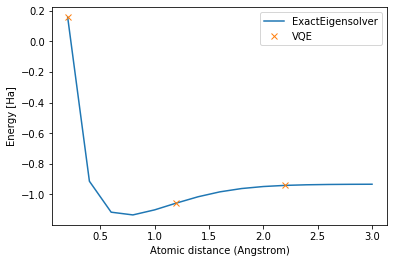

In [152]:
for i, algo in enumerate(algos):
    if algo == 'VQE':
        plt.plot(mol_distances_vqe, energy_vqe[i], label=algo, linestyle='', marker='x')
    else:
        plt.plot(mol_distances, energy[i], label=algo)
        
plt.xlabel('Atomic distance (Angstrom)')
plt.ylabel('Energy [Ha]')
plt.legend()
plt.show()

We want now to visualise the error we are making with the exact solution. 

Errors |Exact - VQE|:
 [0.006692877264558028, 1.3886669592011458e-12, 0.0007071586979825462]


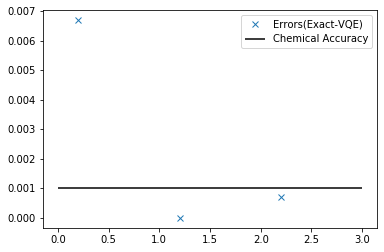

In [184]:
mol_distances_errors = []
energy_errors = []

for i, pts_vqe in enumerate(mol_distances_vqe):
    for j, pts in enumerate(mol_distances):
        # find the entries with same bond distances
        if pts_vqe == pts:
            mol_distances_errors.append(pts)
            energy_errors.append(abs(energy[0][j]-energy_vqe[1][i]))
            
# plot the errors
print('Errors |Exact - VQE|:\n',energy_errors)
plt.plot(mol_distances_errors, energy_errors, label='Errors(Exact-VQE)', linestyle='', marker='x')

# chemical accuracy of 1 mHa
plt.hlines(0.001, 0, 3, colors='k', label='Chemical Accuracy')
plt.legend()
plt.show()

# Exercises

- Set the VQE for H2 using UCCSD, RYRZ, SWAPRZ in STO-3G and compare the results for a given geometry using state_vector simulator with L_BFGS_B optimizer. What is the error with respect to UCCSD ?
- Change depth parameter (repetition of circuit with independent parameters) of RYRZ, SWAPRZ circuit to reach chemical accuracy.
- Change just the basis set from STO-3G to 6-31G and play with active_occupied/unoccupied orbital parameters (change of active space) in UCCSD Variational Form. This is basically the work we performed in [2] so you will be performing ! :-)

[2] Panagiotis Kl. Barkoutsos, Jerome F. Gonthier, Igor Sokolov, Nikolaj Moll, Gian Salis, Andreas Fuhrer, Marc Ganzhorn, Daniel J. Egger, Matthias Troyer, Antonio Mezzacapo, Stefan Filipp, and Ivano Tavernelli *Quantum algorithms for electronic structure calculations: Particle-hole Hamiltonian and optimized wave-function expansions* Phys. Rev. A 98, 022322 – Published 20 August 2018


In [195]:
import qiskit.tools.jupyter
%qiskit_version_table
%qiskit_copyright